# Purpose 

The purpose of this workbook is to clean up data and engineer features to place into my linear regression model. All data was scraped from the BIllboard top 100 chart from April 2012 to April 2019 as well as Spotify's API to grab the audio features for each of the Billboard songs. 

First, I will import of the libraries I will be using for my cleaning.

In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import numpy as np 
import seaborn as sns
sns.set_palette('pastel')

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Next I will load in the csv file that contains all of my Billboard and Spotify information. I created a script that iterated through the songs on the Billboard charts and pulled the audio features for each song and populated a new csv file that combined the two information.

In [2]:
## Load in data
df = pd.read_csv('song_features_all.csv', index_col=False)

## Drop unnecessary columns pulled from Spotify (ie: type, uri, id, track_href, and analysis url)

df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1)
df.head()

,week_of,rank,title,artist,last_week,peak_position,week_on_chart,year,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2012-04-14,1,We Are Young,fun. Featuring Janelle Monae,1,1.0,15.0,2012,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-04-14,2,Boyfriend,Justin Bieber,NaN,NaN,NaN,2012,0.717,0.550,...,-6.019,0.0,0.0521,0.0358,0.001960,0.126,0.332,96.976,171333.0,4.0
2,2012-04-14,3,Somebody That I Used To Know,Gotye Featuring Kimbra,4,3.0,13.0,2012,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-04-14,4,Glad You Came,The Wanted,3,3.0,12.0,2012,0.755,0.838,...,-4.500,0.0,0.0687,0.0643,0.000016,0.118,0.473,126.877,198187.0,4.0
4,2012-04-14,5,Stronger (What Doesn't Kill You),Kelly Clarkson,2,1.0,15.0,2012,0.562,0.939,...,-4.282,1.0,0.0475,0.0460,0.000000,0.112,0.684,116.044,221947.0,4.0


# Data Cleaning

From scraping the Billboard chart, I know that there are a lot of duplicate values when it comes to the songs that appear in our data. To deal with these duplicates, I will first group the songs by title and artist and sort by rank. I will then drop all other rows that the song appears, keeping only the highest rank the song has appeared on the chart.

In [3]:
final = (df
 .groupby(['title', 'artist'], as_index=True)
 .apply(lambda x: x.sort_values(['rank'], ascending=True)))

final.head()

week_of  rank       title  \
title      artist                                                             
#Beautiful Mariah Carey Featuring Miguel 6214  2013-06-22    15  #Beautiful   
                                         6314  2013-06-29    15  #Beautiful   
                                         6415  2013-07-06    16  #Beautiful   
                                         6116  2013-06-15    17  #Beautiful   
                                         6516  2013-07-13    17  #Beautiful   

                                                                      artist  \
title      artist                                                              
#Beautiful Mariah Carey Featuring Miguel 6214  Mariah Carey Featuring Miguel   
                                         6314  Mariah Carey Featuring Miguel   
                                         6415  Mariah Carey Featuring Miguel   
                                         6116  Mariah Carey Featuring Miguel   
                                         6516  Mariah Carey Featuring Miguel   

                                              last_week  peak_position  \
title      artist                                                        
#Beautiful Mariah Carey Featuring Miguel 6214        17           15.0   
                                         6314        15           15.0   
                                         6415        15           15.0   
                                         6116        20           17.0   
                                         6516        16           15.0   

                                               week_on_chart  year  \
title      artist                                                    
#Beautiful Mariah Carey Featuring Miguel 6214            5.0  2013   
                                         6314            6.0  2013   
                                         6415            7.0  2013   
                                         6116            4.0  2013   
                                         6516            8.0  2013   

                                               danceability  energy  \
title      artist                                                     
#Beautiful Mariah Carey Featuring Miguel 6214           NaN     NaN   
                                         6314           NaN     NaN   
                                         6415           NaN     NaN   
                                         6116           NaN     NaN   
                                         6516           NaN     NaN   

                                                    ...        loudness  mode  \
title      artist                                   ...                         
#Beautiful Mariah Carey Featuring Miguel 6214       ...             NaN   NaN   
                                         6314       ...             NaN   NaN   
                                         6415       ...             NaN   NaN   
                                         6116       ...             NaN   NaN   
                                         6516       ...             NaN   NaN   

                                               speechiness  acousticness  \
title      artist                                                          
#Beautiful Mariah Carey Featuring Miguel 6214          NaN           NaN   
                                         6314          NaN           NaN   
                                         6415          NaN           NaN   
                                         6116          NaN           NaN   
                                         6516          NaN           NaN   

                                               instrumentalness  liveness  \
title      artist                                                           
#Beautiful Mariah Carey Featuring Miguel 6214               NaN       NaN   
                                         6314               NaN       NaN   
                  

In [4]:
(final
 .drop_duplicates(subset=['title', 'artist'], keep='first', inplace=True))

Another feature I want to include is how many songs the main artist of a song has had on the Billboard charts. Because I've already deleted duplicates that will be a little easier. First I will identify cases in which there are duets, collaborations and, or multiple artists on one song. Then, I will split on "Featuring" to split the artists into a list. Once that is done, I will count how many times the artist has appeared on the charts and merge onto the original DataFrame. 

In [5]:
# Replace all other delimiters to 'Featuring'
final['artist'] = final.artist.str.replace(',', 'Featuring').str.replace('&', 'Featuring')

# Split on Featuring 
final['artist'] = final.artist.str.split('Featuring')

# use set to remove duplicates
artist_list = set()
for a in final['artist']:
    artist_list.update([elt.strip() for elt in a])

# Convert back to list 
artist_list = list(artist_list)

# Use counter to count the amount of times they have appeared 
from collections import Counter
artist_counter = Counter()
for a in final['artist']:
    artist_counter.update([elt.strip() for elt in a])

# convert series to dataframe 
art_counter = pd.DataFrame(pd.Series(artist_counter), columns=['total_songs_on_chart'])

# Create new column called main artist to identify the main artist in a collaboration
final['main_artist'] = final['artist'].apply(lambda x: x[0].strip())

# merge the two together 
final = final.merge(art_counter, how='left', left_on='main_artist', right_index=True)

# Preview
final.head()

,,,week_of,rank,title,artist,last_week,peak_position,week_on_chart,year,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,main_artist,total_songs_on_chart
title,artist,,,,,,,,,,,,,,,,,,,,,,
#Beautiful,Mariah Carey Featuring Miguel,6214,2013-06-22,15,#Beautiful,"[Mariah Carey , Miguel]",17,15.0,5.0,2013,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mariah Carey,5
#SELFIE,The Chainsmokers,10315,2014-04-05,16,#SELFIE,[The Chainsmokers],18,16.0,4.0,2014,0.807,0.916,...,0.2260,0.01340,0.000012,0.0787,0.651,127.973,183750.0,4.0,The Chainsmokers,15
#thatPOWER,will.i.am Featuring Justin Bieber,5616,2013-05-11,17,#thatPOWER,"[will.i.am , Justin Bieber]",43,17.0,6.0,2013,0.797,0.608,...,0.0583,0.00112,0.000077,0.0748,0.403,128.000,279507.0,4.0,will.i.am,6
$ave Dat Money,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,18270,2015-10-10,71,$ave Dat Money,"[Lil Dicky , Fetty Wap , Rich Homie Quan]",NaN,NaN,NaN,2015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lil Dicky,2
(Kissed You) Good Night,Gloriana,1833,2012-08-18,34,(Kissed You) Good Night,[Gloriana],36,34.0,18.0,2012,0.523,0.747,...,0.0292,0.08070,0.000000,0.1100,0.294,118.970,232903.0,4.0,Gloriana,2


In [6]:
final['average_rank'] = df.groupby(['title','artist'])[['rank']].mean()
final.head()

,,,week_of,rank,title,artist,last_week,peak_position,week_on_chart,year,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,main_artist,total_songs_on_chart,average_rank
title,artist,,,,,,,,,,,,,,,,,,,,,,
#Beautiful,Mariah Carey Featuring Miguel,6214,2013-06-22,15,#Beautiful,"[Mariah Carey , Miguel]",17,15.0,5.0,2013,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mariah Carey,5,36.812500
#SELFIE,The Chainsmokers,10315,2014-04-05,16,#SELFIE,[The Chainsmokers],18,16.0,4.0,2014,0.807,0.916,...,0.01340,0.000012,0.0787,0.651,127.973,183750.0,4.0,The Chainsmokers,15,42.545455
#thatPOWER,will.i.am Featuring Justin Bieber,5616,2013-05-11,17,#thatPOWER,"[will.i.am , Justin Bieber]",43,17.0,6.0,2013,0.797,0.608,...,0.00112,0.000077,0.0748,0.403,128.000,279507.0,4.0,will.i.am,6,43.062500
$ave Dat Money,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,18270,2015-10-10,71,$ave Dat Money,"[Lil Dicky , Fetty Wap , Rich Homie Quan]",NaN,NaN,NaN,2015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lil Dicky,2,85.315789
(Kissed You) Good Night,Gloriana,1833,2012-08-18,34,(Kissed You) Good Night,[Gloriana],36,34.0,18.0,2012,0.523,0.747,...,0.08070,0.000000,0.1100,0.294,118.970,232903.0,4.0,Gloriana,2,58.050000


I will add the total number of weeks the song has appeared on the chart, based on the `week_on_chart` column. To do this, I will create a dataframe based on grouping the song titles and artists, then I will sort the `week_on_chart` column in descending order so that the first value will be the highest value and also the last time the song appeared on the chart. 

Because some songs only appeared on the chart once, the value for that column will be 0, because the song had not appeared previously. In those cases, I will add a 1 because they appeared on the chart once. In addition, those with a value, I will also add a one to the listed value to capture the last week they appeared on the chart, that is not captured by the number in the `week_on_chart` value. 

In [7]:
weeks = (df
 .groupby(['title', 'artist'], as_index=True)
 .apply(lambda x: x.sort_values(['week_on_chart'], ascending=False)))

In [8]:
(weeks
 .drop_duplicates(subset=['title', 'artist'], keep='first', inplace=True))

In [9]:
weeks_on_chart = []
for row in weeks['week_on_chart']:
    if np.isnan(row):
        weeks_on_chart.append(float(1))
    else:
        weeks_on_chart.append(float(row) + 1.0)
weeks_on_chart[1:5]

[12.0, 17.0, 20.0, 21.0]

In [10]:
final['total_weeks_on_chart'] = weeks_on_chart

A couple of other features I will add are the rank and total amount of weeks of an artist's previous song as well as the average previous rank and average previous total amount of weeks. I will also add the amount of songs previously on the charts.

To do this, I will sort the columns by the artist, year and week of the chart, group by the artist and use the shift function to shift values down in chronological order. This will give me the previous rank and total weeks on the chart. Next, to get the average, I will take the cumultive sum and divide by the cumulative count.

In [11]:
# Create previous rank column
final['prev_rank'] = (final.sort_values(['main_artist','year','week_of'], ascending=True)
                      .groupby(['main_artist'], as_index=True)
                      .shift()['rank'])

In [12]:
# Create previous total weeks on chart (twoc)
final['prev_twoc'] = (final.sort_values(['main_artist','year','week_of'], ascending=True)
                      .groupby(['main_artist'], as_index=True)
                      .shift()['total_weeks_on_chart'])

In [13]:
# Create previous total number of songs on the chart
final['prev_total_songs'] = (final.sort_values(['main_artist', 'year', 'week_of'], ascending=True)
                             .groupby('main_artist').cumcount()+1)

In [14]:
# Taking the above, create average previous rank
final['avg_prev_rank'] = (final.groupby('main_artist').cumsum()['prev_rank']/(final.groupby('main_artist').cumcount()+1))

In [15]:
# Taking the above, create average previous total weeks on chart
final['avg_prev_twoc'] = (final.groupby('main_artist').cumsum()['prev_twoc']/(final.groupby('main_artist').cumcount()+1))


Looking at the previous, there are a lot of N/A's and inf values, which makes sense for songs that are either the first song that was on the chart for the artist or if a value was divided by 0. To get rid of these, I will replace them with 0's. 

In [16]:
final.replace({'prev_rank': np.nan, 'prev_twoc': np.nan}, 0, inplace=True)
final.replace({'avg_prev_rank': {np.nan: 0, np.inf: 0}, 'avg_prev_twoc': {np.nan: 0, np.inf: 0}}, inplace=True)
final.head()

,,,week_of,rank,title,artist,last_week,peak_position,week_on_chart,year,danceability,energy,...,time_signature,main_artist,total_songs_on_chart,average_rank,total_weeks_on_chart,prev_rank,prev_twoc,prev_total_songs,avg_prev_rank,avg_prev_twoc
title,artist,,,,,,,,,,,,,,,,,,,,,,
#Beautiful,Mariah Carey Featuring Miguel,6214,2013-06-22,15,#Beautiful,"[Mariah Carey , Miguel]",17,15.0,5.0,2013,NaN,NaN,...,NaN,Mariah Carey,5,36.812500,17.0,0.0,0.0,1,0.0,0.0
#SELFIE,The Chainsmokers,10315,2014-04-05,16,#SELFIE,[The Chainsmokers],18,16.0,4.0,2014,0.807,0.916,...,4.0,The Chainsmokers,15,42.545455,12.0,0.0,0.0,1,0.0,0.0
#thatPOWER,will.i.am Featuring Justin Bieber,5616,2013-05-11,17,#thatPOWER,"[will.i.am , Justin Bieber]",43,17.0,6.0,2013,0.797,0.608,...,4.0,will.i.am,6,43.062500,17.0,58.0,1.0,3,58.0,1.0
$ave Dat Money,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,18270,2015-10-10,71,$ave Dat Money,"[Lil Dicky , Fetty Wap , Rich Homie Quan]",NaN,NaN,NaN,2015,NaN,NaN,...,NaN,Lil Dicky,2,85.315789,20.0,0.0,0.0,1,0.0,0.0
(Kissed You) Good Night,Gloriana,1833,2012-08-18,34,(Kissed You) Good Night,[Gloriana],36,34.0,18.0,2012,0.523,0.747,...,4.0,Gloriana,2,58.050000,21.0,0.0,0.0,1,0.0,0.0


In [17]:
final.shape

(3133, 30)

In [18]:
final.dropna(subset=['danceability'], inplace=True)
final = final.drop(['last_week','peak_position', 'week_on_chart'], axis=1)
final.shape

(2285, 27)

As a check, let's see the top 20 artists who have the most songs on the chart.

In [19]:
chart = final.groupby(['main_artist', 'year'])['main_artist'].count().unstack('year').fillna(0)
chart.head()

year,2012,2013,2014,2015,2016,2017,2018,2019
main_artist,,,,,,,,
"""Weird Al"" Yankovic",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2 Chainz,3.0,3.0,0.0,0.0,2.0,2.0,1.0,0.0
21 Savage,0.0,0.0,0.0,0.0,0.0,4.0,0.0,9.0
5 Seconds Of Summer,0.0,0.0,6.0,3.0,0.0,0.0,2.0,0.0
6LACK,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
chart['total'] = chart.sum(axis=1)
chart.head()

year,2012,2013,2014,2015,2016,2017,2018,2019,total
main_artist,,,,,,,,,
"""Weird Al"" Yankovic",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2 Chainz,3.0,3.0,0.0,0.0,2.0,2.0,1.0,0.0,11.0
21 Savage,0.0,0.0,0.0,0.0,0.0,4.0,0.0,9.0,13.0
5 Seconds Of Summer,0.0,0.0,6.0,3.0,0.0,0.0,2.0,0.0,11.0
6LACK,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
top_20_artist = chart.sort_values(by=['total'], ascending=False).head(20)
top_20_artist.reset_index(level=0, inplace=True)
top_20_artist

year,main_artist,2012,2013,2014,2015,2016,2017,2018,2019,total
0,Drake,3.0,13.0,1.0,23.0,19.0,23.0,20.0,0.0,102.0
1,Future,2.0,3.0,2.0,5.0,4.0,13.0,6.0,7.0,42.0
2,Ariana Grande,0.0,5.0,3.0,4.0,5.0,2.0,9.0,11.0,39.0
3,The Weeknd,0.0,1.0,0.0,11.0,16.0,2.0,6.0,0.0,36.0
4,Justin Bieber,6.0,10.0,0.0,12.0,2.0,0.0,0.0,0.0,30.0
5,One Direction,3.0,9.0,7.0,9.0,0.0,0.0,0.0,0.0,28.0
6,Taylor Swift,7.0,4.0,4.0,5.0,1.0,4.0,2.0,0.0,27.0
7,J. Cole,2.0,2.0,1.0,2.0,12.0,0.0,6.0,1.0,26.0
8,Kanye West,2.0,4.0,0.0,2.0,9.0,0.0,8.0,0.0,25.0
9,Post Malone,0.0,0.0,0.0,0.0,2.0,3.0,18.0,1.0,24.0


In [32]:
top_20_artist.to_csv('top_20.csv', index=False)

Text(0, 0.5, 'Number of Songs')

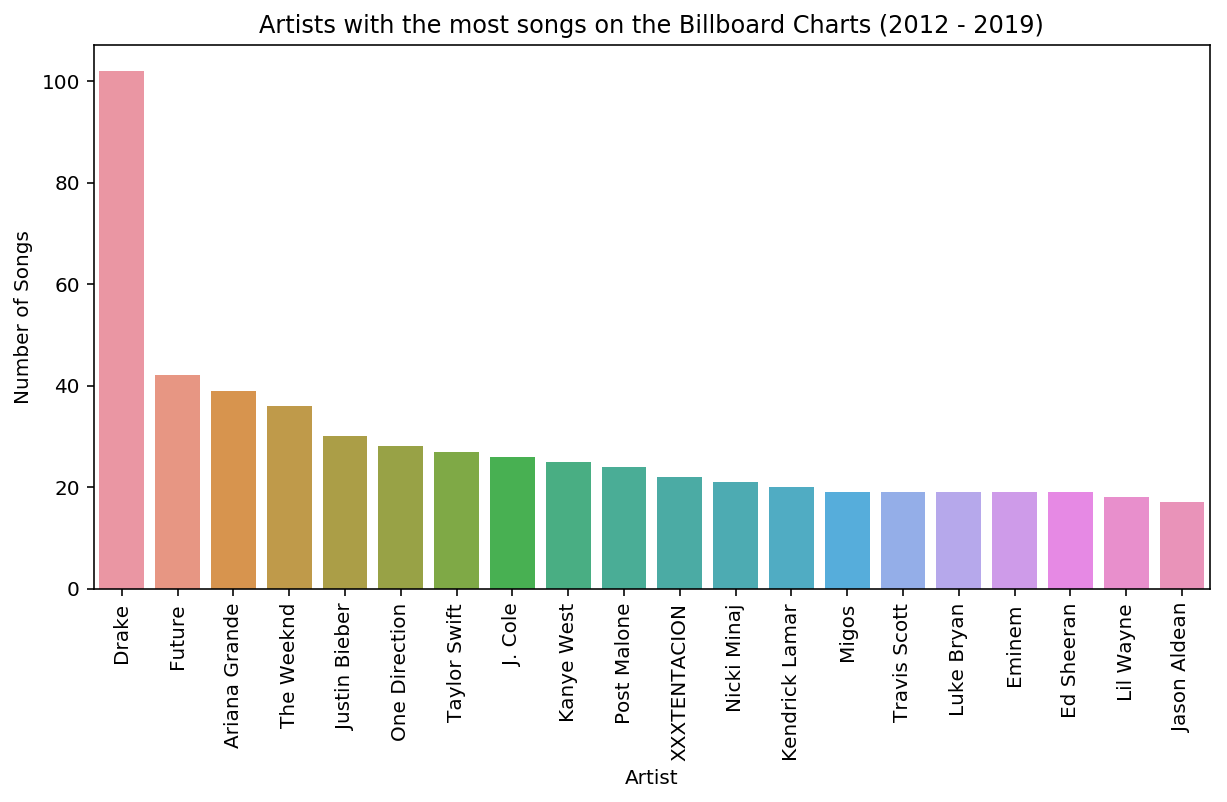

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_20_artist['main_artist'], y=top_20_artist['total'])
plt.xticks(rotation=90)
plt.title('Artists with the most songs on the Billboard Charts (2012 - 2019)')
plt.xlabel('Artist')
plt.ylabel('Number of Songs')

Drake has the most singles by far. This may be an outlier, but for now, let's keep it in and regularize it when we are doing our linear regression work. 

Next, I will drop all the N/A's that could not be found in Spotify. Then, I will reset the index of the dataframe so we have a clean dataframe for our analysis.

In [22]:
final = final.reset_index(drop=True)
final.head()

,week_of,rank,title,artist,year,danceability,energy,key,loudness,mode,...,time_signature,main_artist,total_songs_on_chart,average_rank,total_weeks_on_chart,prev_rank,prev_twoc,prev_total_songs,avg_prev_rank,avg_prev_twoc
0,2014-04-05,16,#SELFIE,[The Chainsmokers],2014,0.807,0.916,0.0,-3.282,1.0,...,4.0,The Chainsmokers,15,42.545455,12.0,0.0,0.0,1,0.0,0.0
1,2013-05-11,17,#thatPOWER,"[will.i.am , Justin Bieber]",2013,0.797,0.608,6.0,-6.096,0.0,...,4.0,will.i.am,6,43.062500,17.0,58.0,1.0,3,58.0,1.0
2,2012-08-18,34,(Kissed You) Good Night,[Gloriana],2012,0.523,0.747,11.0,-6.125,1.0,...,4.0,Gloriana,2,58.050000,21.0,0.0,0.0,1,0.0,0.0
3,2019-01-05,32,(There's No Place Like) Home For The Holidays,[Perry Como],2019,0.541,0.441,5.0,-9.692,1.0,...,4.0,Perry Como,1,36.500000,3.0,0.0,0.0,1,0.0,0.0
4,2017-09-23,4,...Ready For It?,[Taylor Swift],2017,0.613,0.764,2.0,-6.509,1.0,...,4.0,Taylor Swift,33,41.736842,21.0,1.0,21.0,27,1.0,21.0


In [23]:
# Describe columns
final.describe()

,rank,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,duration_ms,time_signature,total_songs_on_chart,average_rank,total_weeks_on_chart,prev_rank,prev_twoc,prev_total_songs,avg_prev_rank,avg_prev_twoc
count,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,...,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000,2285.000000
mean,49.182932,2015.589497,0.646487,0.661028,5.153611,-6.195461,0.650766,0.113758,0.179401,0.006986,...,220042.116849,3.972429,23.393873,64.025529,14.050328,35.262144,10.849015,8.788184,31.465988,9.922908
std,29.339739,2.134176,0.140692,0.174581,3.593088,2.335156,0.476832,0.115096,0.223238,0.052250,...,46686.908041,0.265717,33.764894,23.360064,12.423024,32.362764,12.756011,14.023646,23.917108,8.741687
min,1.000000,2012.000000,0.144000,0.054900,0.000000,-23.237000,0.000000,0.023100,0.000030,0.000000,...,73813.000000,1.000000,1.000000,1.363636,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,24.000000,2014.000000,0.554000,0.549000,1.000000,-7.323000,0.000000,0.038800,0.023500,0.000000,...,193511.000000,4.000000,4.000000,47.772727,3.000000,1.000000,1.000000,2.000000,1.000000,0.500000
50%,50.000000,2016.000000,0.647000,0.683000,5.000000,-5.835000,1.000000,0.059000,0.080700,0.000000,...,215733.000000,4.000000,11.000000,68.166667,12.000000,30.000000,4.000000,4.000000,34.411765,9.516129
75%,74.000000,2017.000000,0.743000,0.798000,8.000000,-4.605000,1.000000,0.144000,0.254000,0.000014,...,240005.000000,4.000000,29.000000,83.000000,21.000000,62.000000,21.000000,10.000000,47.400000,15.666667
max,100.000000,2019.000000,0.981000,0.991000,11.000000,-0.698000,1.000000,0.740000,0.978000,0.918000,...,688453.000000,5.000000,156.000000,100.000000,88.000000,100.000000,88.000000,112.000000,100.000000,60.000000


In [24]:
# Write to csv
final.to_csv('final_clean.csv', index=False)